<a href="https://colab.research.google.com/github/PoommipatWat/ANN/blob/main/HW2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy matplotlib

In [ ]:
from google.colab import files
uploaded = files.upload()  # อัพโหลดไฟล์ .pat ทั้ง 3 ไฟล์

Saving cross.pat to cross.pat
Saving ellipse.pat to ellipse.pat
Saving iris.pat to iris (1).pat


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NN:
    def __init__(self,
                 learning_rate: float = 0.1,
                 momentum_rate: float = 0.1,
                 layer: list[int] = None) -> None:
        self.lr = learning_rate
        self.mr = momentum_rate
        self._init_layer(layer)
        self.y = None
        self.errors = []

    def _init_layer(self, layer: list[int]) -> None:
        self.layer = layer
        self.weights = [np.random.rand(layer[i], layer[i+1]) for i in range(len(layer)-1)]
        self.bias = [np.random.rand(1, layer[i+1]) for i in range(len(layer)-1)]
        self.delta_weights = [np.zeros((layer[i], layer[i+1])) for i in range(len(layer)-1)]
        self.delta_bias = [np.zeros((1, layer[i+1])) for i in range(len(layer)-1)]

    def _sigmoid(self, v) -> np.ndarray:
        return 1 / (1 + np.exp(-v))

    def _sigmoid_derivative(self, y) -> np.ndarray:
        return y * (1 - y)

    def _forward(self, x: np.ndarray) -> None:
        self.y = [x]
        for i in range(len(self.layer)-1):
            v = np.dot(self.y[-1], self.weights[i]) + self.bias[i]
            self.y.append(self._sigmoid(v))

    def _backward(self, desired_output) -> None:
        error = desired_output - self.y[-1]
        local_gradient_output = error * self._sigmoid_derivative(self.y[-1])

        local_gradient = [local_gradient_output]
        for i in range(len(self.layer)-2, 0, -1):
            local_gradient.append(
                (local_gradient[-1] @ (self.weights[i].T)) *
                self._sigmoid_derivative(self.y[i])
            )

        for i in range(len(self.layer)-1):
            self.delta_weights[i] = (
                self.lr * (self.y[i].T @ local_gradient[-i-1]) +
                self.mr * self.delta_weights[i]
            )
            self.delta_bias[i] = (
                self.lr * np.sum(local_gradient[-i-1], axis=0) +
                self.mr * self.delta_bias[i]
            )

        for i in range(len(self.layer)-1):
            self.weights[i] += self.delta_weights[i]
            self.bias[i] += self.delta_bias[i]

    def _sum_squared_error(self, d: np.ndarray) -> float:
        return np.mean(np.square(d - self.y[-1]))

    def train(self, x: np.ndarray, d: np.ndarray, epoches: int = 10000,
             desired_error: float = 0.01, plot: bool = True) -> None:
        self.errors = []
        num_epoches = 0

        while num_epoches < epoches:
            epoch_errors = []
            indices = np.random.permutation(len(x))
            x_shuffled = x[indices]
            d_shuffled = d[indices]

            for i in range(len(x_shuffled)):
                self._forward(x_shuffled[i:i+1])
                self._backward(d_shuffled[i:i+1])
                sse = self._sum_squared_error(d_shuffled[i:i+1])
                epoch_errors.append(sse)

            avg_error = np.mean(epoch_errors)
            self.errors.append(avg_error)

            if num_epoches % 1000 == 0:
                print(f"Epoch {num_epoches}: {self.errors[-1]:.10f}")

            if avg_error < desired_error:
                break

            num_epoches += 1

    def predict(self, x: np.ndarray) -> np.ndarray:
        self._forward(x)
        return self.y[-1]

    def k_fold_cross_validation(self, x: np.ndarray, d: np.ndarray, k: int = 5,
                              epoches: int = 10000, desired_error: float = 0.01,
                              plot: bool = True) -> tuple:
        fold_size = len(x) // k
        indices = np.random.permutation(len(x))
        x_shuffled = x[indices]
        d_shuffled = d[indices]

        fold_errors = []

        for fold in range(k):
            print(f"\nFold {fold+1}/{k}")

            test_start = fold * fold_size
            test_end = test_start + fold_size

            x_test = x_shuffled[test_start:test_end]
            d_test = d_shuffled[test_start:test_end]

            x_train = np.concatenate([x_shuffled[:test_start], x_shuffled[test_end:]])
            d_train = np.concatenate([d_shuffled[:test_start], d_shuffled[test_end:]])

            self._init_layer(self.layer)

            self.train(x_train, d_train, epoches=epoches,
                      desired_error=desired_error, plot=plot)

            test_errors = []
            for i in range(len(x_test)):
                self._forward(x_test[i:i+1])
                error = self._sum_squared_error(d_test[i:i+1])
                test_errors.append(error)

            fold_errors.append(np.mean(test_errors))
            print(f"Fold {fold+1} Error: {fold_errors[-1]:.10f}")

        mean_error = np.mean(fold_errors)
        std_error = np.std(fold_errors)
        print(f"\nMean Error: {mean_error:.10f}")
        print(f"Standard Deviation: {std_error:.10f}")

        return mean_error, std_error

In [ ]:
def calculate_accuracy(predicted: np.ndarray, desired: np.ndarray) -> float:
    pred_classes = np.argmax(predicted, axis=1)
    true_classes = np.argmax(desired, axis=1)
    return np.mean(pred_classes == true_classes)

def experiment(x: np.ndarray,
              d: np.ndarray,
              hidden_layers: list[list[int]],
              learning_rates: list[float],
              momentum_rates: list[float],
              n_trials: int = 3,
              k_folds: int = 10,
              max_epochs: int = 10000,
              desired_error: float = 0.01) -> tuple:
    results = []
    learning_curves = {}

    for hidden_layer in hidden_layers:
        for lr in learning_rates:
            for mr in momentum_rates:
                config_key = f"h{hidden_layer}_lr{lr}_mr{mr}"
                learning_curves[config_key] = []

                print(f"\nTesting configuration:")
                print(f"Hidden layers: {hidden_layer}")
                print(f"Learning rate: {lr}")
                print(f"Momentum rate: {mr}")

                trial_results = []
                for trial in range(n_trials):
                    print(f"\nTrial {trial + 1}/{n_trials}")

                    layer = [x.shape[1]] + hidden_layer + [d.shape[1]]
                    nn = NN(learning_rate=lr, momentum_rate=mr, layer=layer)

                    mean_error, std_error = nn.k_fold_cross_validation(
                        x, d, k=k_folds, epoches=max_epochs,
                        desired_error=desired_error, plot=False
                    )

                    predictions = nn.predict(x)
                    accuracy = calculate_accuracy(predictions, d)

                    trial_results.append({
                        'accuracy': accuracy,
                        'epochs': len(nn.errors),
                        'final_error': mean_error
                    })

                    learning_curves[config_key].append(nn.errors)

                mean_accuracy = np.mean([r['accuracy'] for r in trial_results])
                std_accuracy = np.std([r['accuracy'] for r in trial_results])
                mean_epochs = np.mean([r['epochs'] for r in trial_results])
                mean_final_error = np.mean([r['final_error'] for r in trial_results])

                results.append({
                    'hidden_layers': hidden_layer,
                    'learning_rate': lr,
                    'momentum_rate': mr,
                    'mean_accuracy': mean_accuracy,
                    'std_accuracy': std_accuracy,
                    'mean_epochs': mean_epochs,
                    'mean_final_error': mean_final_error
                })

    return results, learning_curves

In [ ]:
def plot_comparison(results: list, dataset_name: str) -> None:
    # Plot 1: Accuracy by Network Architecture
    plt.figure(figsize=(1920/100, 1080/100))

    architectures = []
    for r in results:
        hidden = r['hidden_layers']
        arch_str = '-'.join(str(x) for x in hidden)
        architectures.append(arch_str)

    accuracies = [r['mean_accuracy'] for r in results]

    bars = plt.bar(range(len(architectures)), accuracies)

    plt.xticks(range(len(architectures)), architectures,
               rotation=45,
               ha='right',
               fontsize=14)

    plt.title('Accuracy by Network Architecture', fontsize=20, pad=20)
    plt.xlabel('Hidden Layer Nodes', fontsize=16, labelpad=10)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.margins(y=0.1)

    plt.tight_layout()
    plt.savefig(f'{dataset_name}_accuracy.png',
                dpi=100,
                bbox_inches='tight')
    plt.show()
    plt.close()

    # Plot 2: Convergence Speed by Learning Rate
    plt.figure(figsize=(1920/100, 1080/100))

    learning_rates = sorted(list(set(r['learning_rate'] for r in results)))
    epochs_by_lr = {lr: [] for lr in learning_rates}
    for r in results:
        epochs_by_lr[r['learning_rate']].append(r['mean_epochs'])

    box_data = [epochs_by_lr[lr] for lr in learning_rates]
    plt.boxplot(box_data, labels=[f'{lr:.2f}' for lr in learning_rates])

    plt.title('Convergence Speed by Learning Rate', fontsize=20, pad=20)
    plt.xlabel('Learning Rate', fontsize=16, labelpad=10)
    plt.ylabel('Epochs to Converge', fontsize=16)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{dataset_name}_convergence.png',
                dpi=100,
                bbox_inches='tight')
    plt.show()
    plt.close()

    # Plot 3: Final Error by Momentum Rate
    plt.figure(figsize=(1920/100, 1080/100))

    momentum_rates = sorted(list(set(r['momentum_rate'] for r in results)))
    errors_by_mr = {mr: [] for mr in momentum_rates}
    for r in results:
        errors_by_mr[r['momentum_rate']].append(r['mean_final_error'])

    box_data = [errors_by_mr[mr] for mr in momentum_rates]
    plt.boxplot(box_data, labels=[f'{mr:.2f}' for mr in momentum_rates])

    plt.title('Final Error by Momentum Rate', fontsize=20, pad=20)
    plt.xlabel('Momentum Rate', fontsize=16, labelpad=10)
    plt.ylabel('Mean Squared Error', fontsize=16)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{dataset_name}_error.png',
                dpi=100,
                bbox_inches='tight')
    plt.show()
    plt.close()

def plot_learning_curves(learning_curves: dict, dataset_name: str) -> None:
    """พล็อต learning curves แยกตาม architecture"""

    # จัดกลุ่ม learning curves ตาม architecture
    arch_curves = {}
    for config, curves in learning_curves.items():
        # แยก architecture จากชื่อ config (เช่น "h[4, 4]_lr0.1_mr0.0")
        arch = config.split('_')[0][1:]  # ตัด 'h' ออกจากข้างหน้า

        if arch not in arch_curves:
            arch_curves[arch] = {}
        arch_curves[arch][config] = curves

    # วาดกราฟแยกตาม architecture
    for arch, configs in arch_curves.items():
        plt.figure(figsize=(1920/100, 1080/100))

        # สร้างสีที่แตกต่างกันสำหรับแต่ละ configuration
        colors = plt.cm.tab20(np.linspace(0, 1, len(configs)))

        for (config, curves), color in zip(configs.items(), colors):
            # คำนวณค่าเฉลี่ยของ curves จากทุก trial
            mean_curve = np.mean(curves, axis=0)
            std_curve = np.std(curves, axis=0)
            epochs = range(1, len(mean_curve) + 1)

            # สร้าง label ที่อ่านง่ายขึ้น
            label = config.replace('h'+arch+'_', '')  # ตัดชื่อ architecture ออก

            # พล็อตค่าเฉลี่ย
            plt.plot(epochs, mean_curve, label=label, color=color)
            # พล็อต standard deviation
            plt.fill_between(epochs,
                           mean_curve - std_curve,
                           mean_curve + std_curve,
                           alpha=0.2, color=color)

        plt.title(f'Learning Curves Comparison\nArchitecture: {arch}', fontsize=20, pad=20)
        plt.xlabel('Epoch', fontsize=16, labelpad=10)
        plt.ylabel('Mean Squared Error', fontsize=16)
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

        plt.tight_layout()
        plt.savefig(f'{dataset_name}_learning_curves_{arch}.png',
                    dpi=100,
                    bbox_inches='tight')
        plt.show()
        plt.close()

In [ ]:
def read_data(file_path: str, dataset_type: str) -> tuple:
    """อ่านข้อมูลจากไฟล์ตามประเภทของ dataset"""
    x = []
    d = []

    if dataset_type == 'iris':
        with open(file_path, 'r') as f:
            next(f)  # ข้าม header
            for line in f:
                data = line.strip().split('\t')
                features = [float(x) for x in data[:4]]

                label = int(data[4])
                if label == 1:
                    target = [1, 0, 0]
                elif label == 2:
                    target = [0, 1, 0]
                else:
                    target = [0, 0, 1]

                x.append(features)
                d.append(target)

    else:  # cross และ ellipse มีโครงสร้างเหมือนกัน
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for i in range(0, len(lines), 3):  # อ่านทีละ 3 บรรทัด
                data = lines[i+1].strip().split()  # x1, x2
                target = lines[i+2].strip().split()  # target
                x.append([float(data[0]), float(data[1])])
                d.append([float(target[0]), float(target[1])])

    return np.array(x), np.array(d)

def normalization(x: np.ndarray) -> tuple:
    """Normalize input data to range [0,1]"""
    x_min = np.min(x, axis=0)
    x_max = np.max(x, axis=0)
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm, x_min, x_max

เลือกชุดข้อมูลที่ต้องการทดสอบ:
1: Iris Dataset
2: Cross Dataset
3: Ellipse Dataset
4: ทดสอบทั้งหมด
กรุณาเลือก (1-4): 1

Testing with iris dataset:

Testing configuration:
Hidden layers: [4]
Learning rate: 0.1
Momentum rate: 0.0

Trial 1/1

Fold 1/10
Epoch 0: 0.3084134923
Fold 1 Error: 0.2113922749

Fold 2/10
Epoch 0: 0.3938208603
Fold 2 Error: 0.2082338824

Fold 3/10
Epoch 0: 0.2830098606
Fold 3 Error: 0.1873782491

Fold 4/10
Epoch 0: 0.3139006557
Fold 4 Error: 0.2053804210

Fold 5/10
Epoch 0: 0.4021709272
Fold 5 Error: 0.2147022130

Fold 6/10
Epoch 0: 0.2969811562
Fold 6 Error: 0.1986209143

Fold 7/10
Epoch 0: 0.3439212284
Fold 7 Error: 0.1851627998

Fold 8/10
Epoch 0: 0.3592873701
Fold 8 Error: 0.2110482268

Fold 9/10
Epoch 0: 0.3959585508
Fold 9 Error: 0.1936322406

Fold 10/10
Epoch 0: 0.3591706729
Fold 10 Error: 0.2034381176

Mean Error: 0.2018989339
Standard Deviation: 0.0098102526

Testing configuration:
Hidden layers: [4]
Learning rate: 0.1
Momentum rate: 0.4

Trial 1/1

Fold 1/

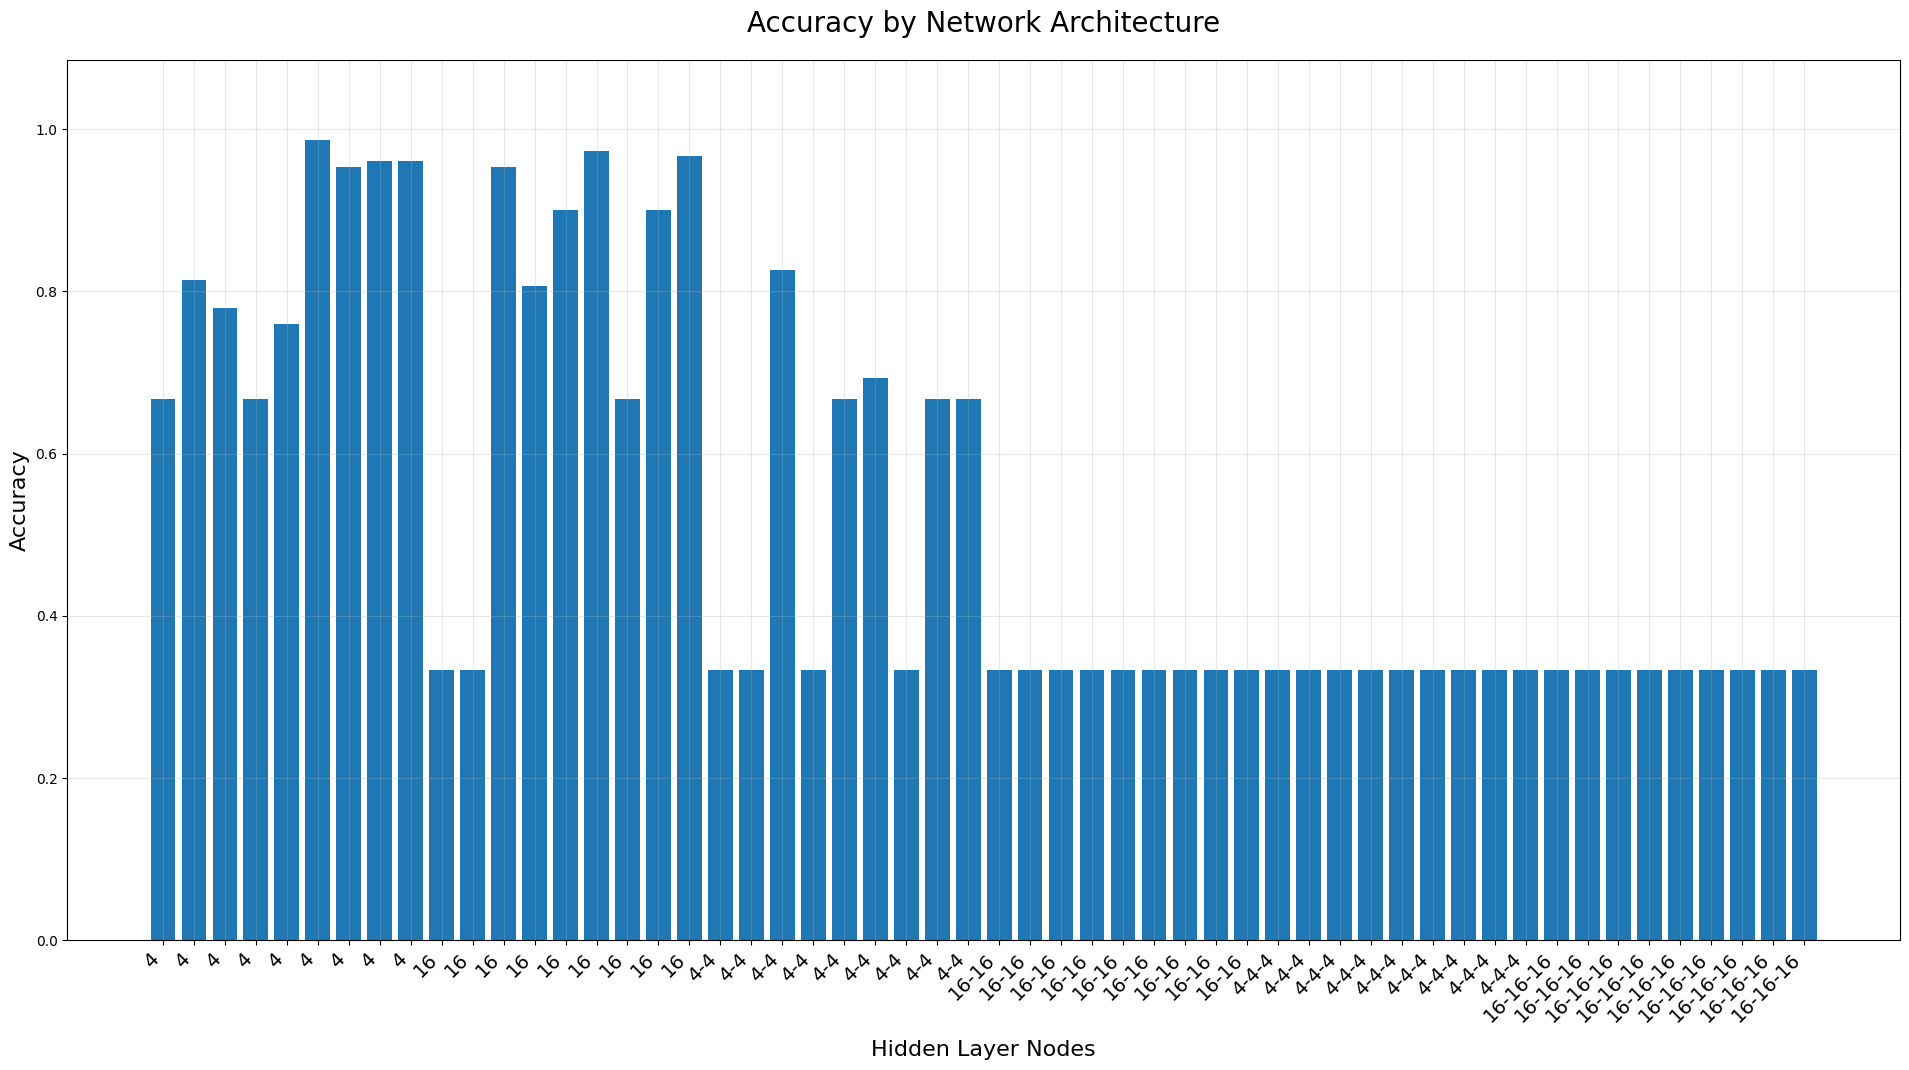

<ipython-input-18-e1b20fcb888a>:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=[f'{lr:.2f}' for lr in learning_rates])


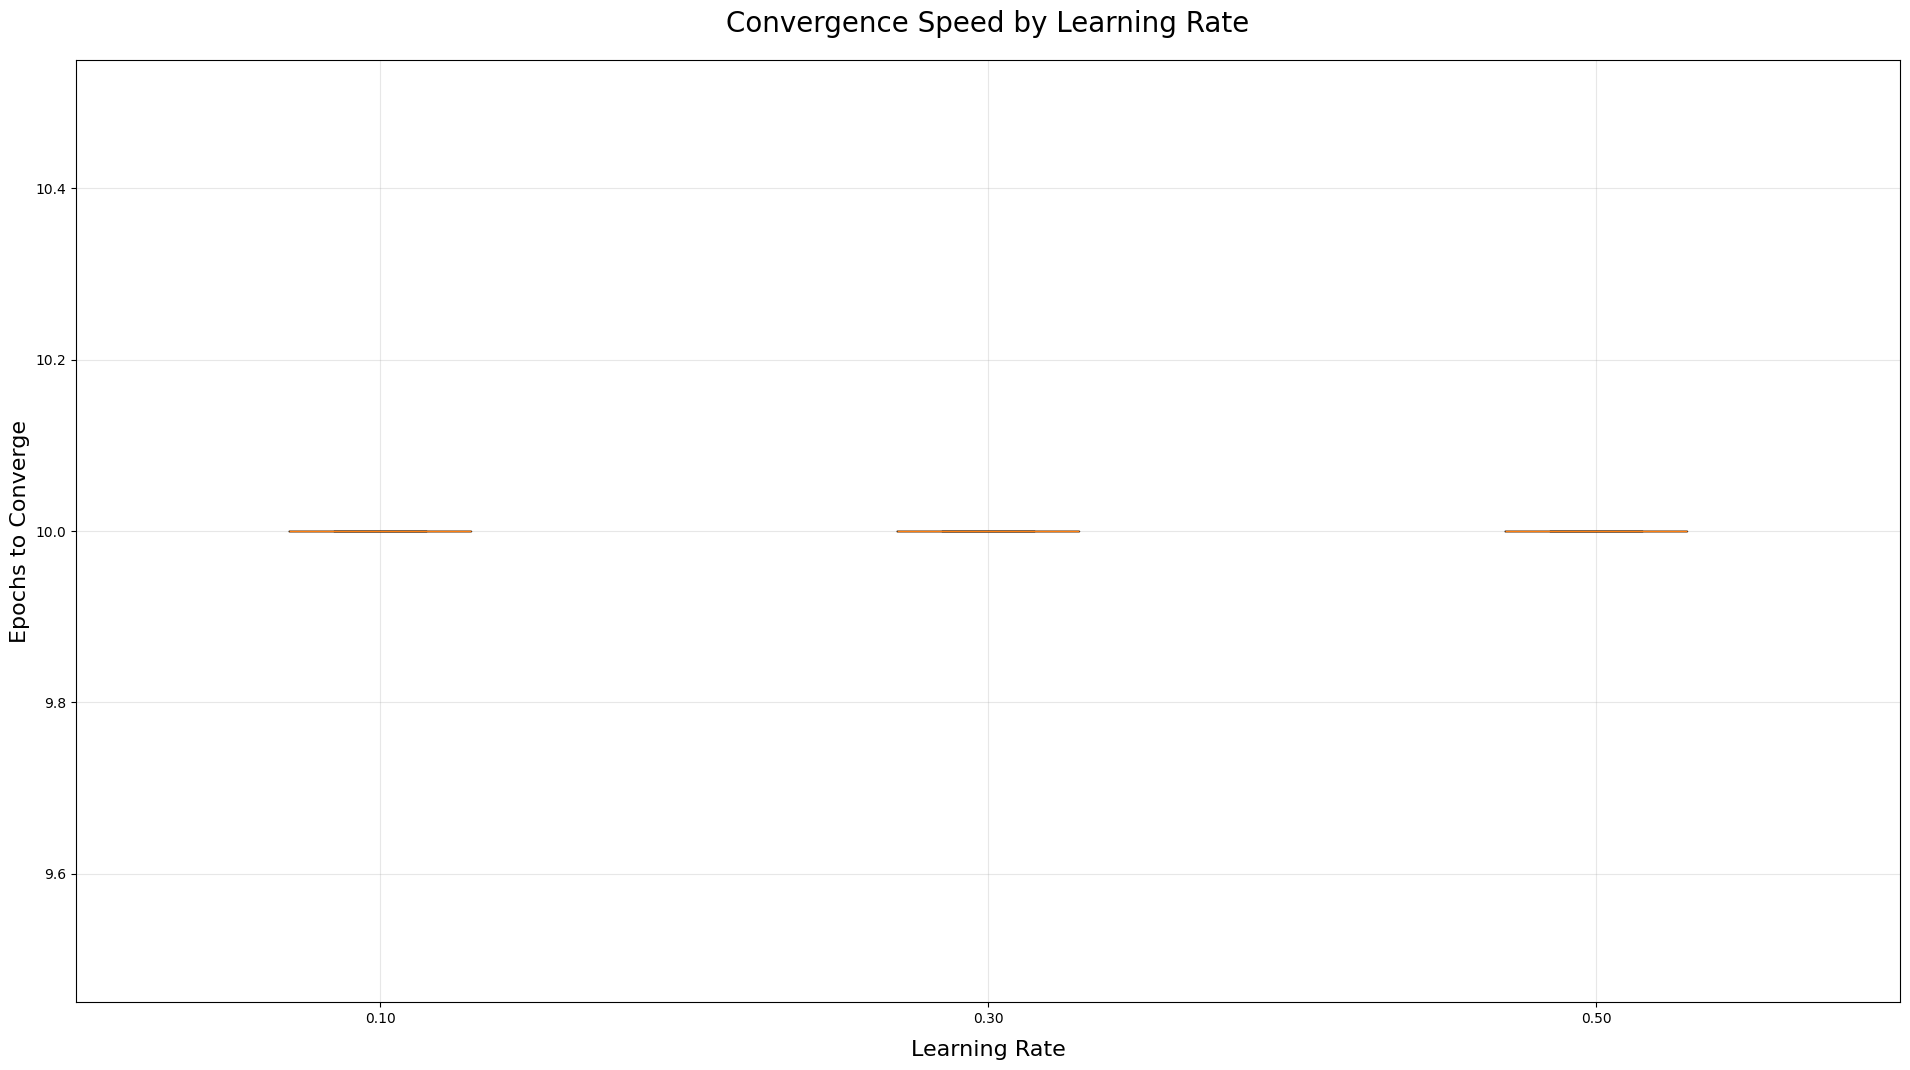

<ipython-input-18-e1b20fcb888a>:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=[f'{mr:.2f}' for mr in momentum_rates])


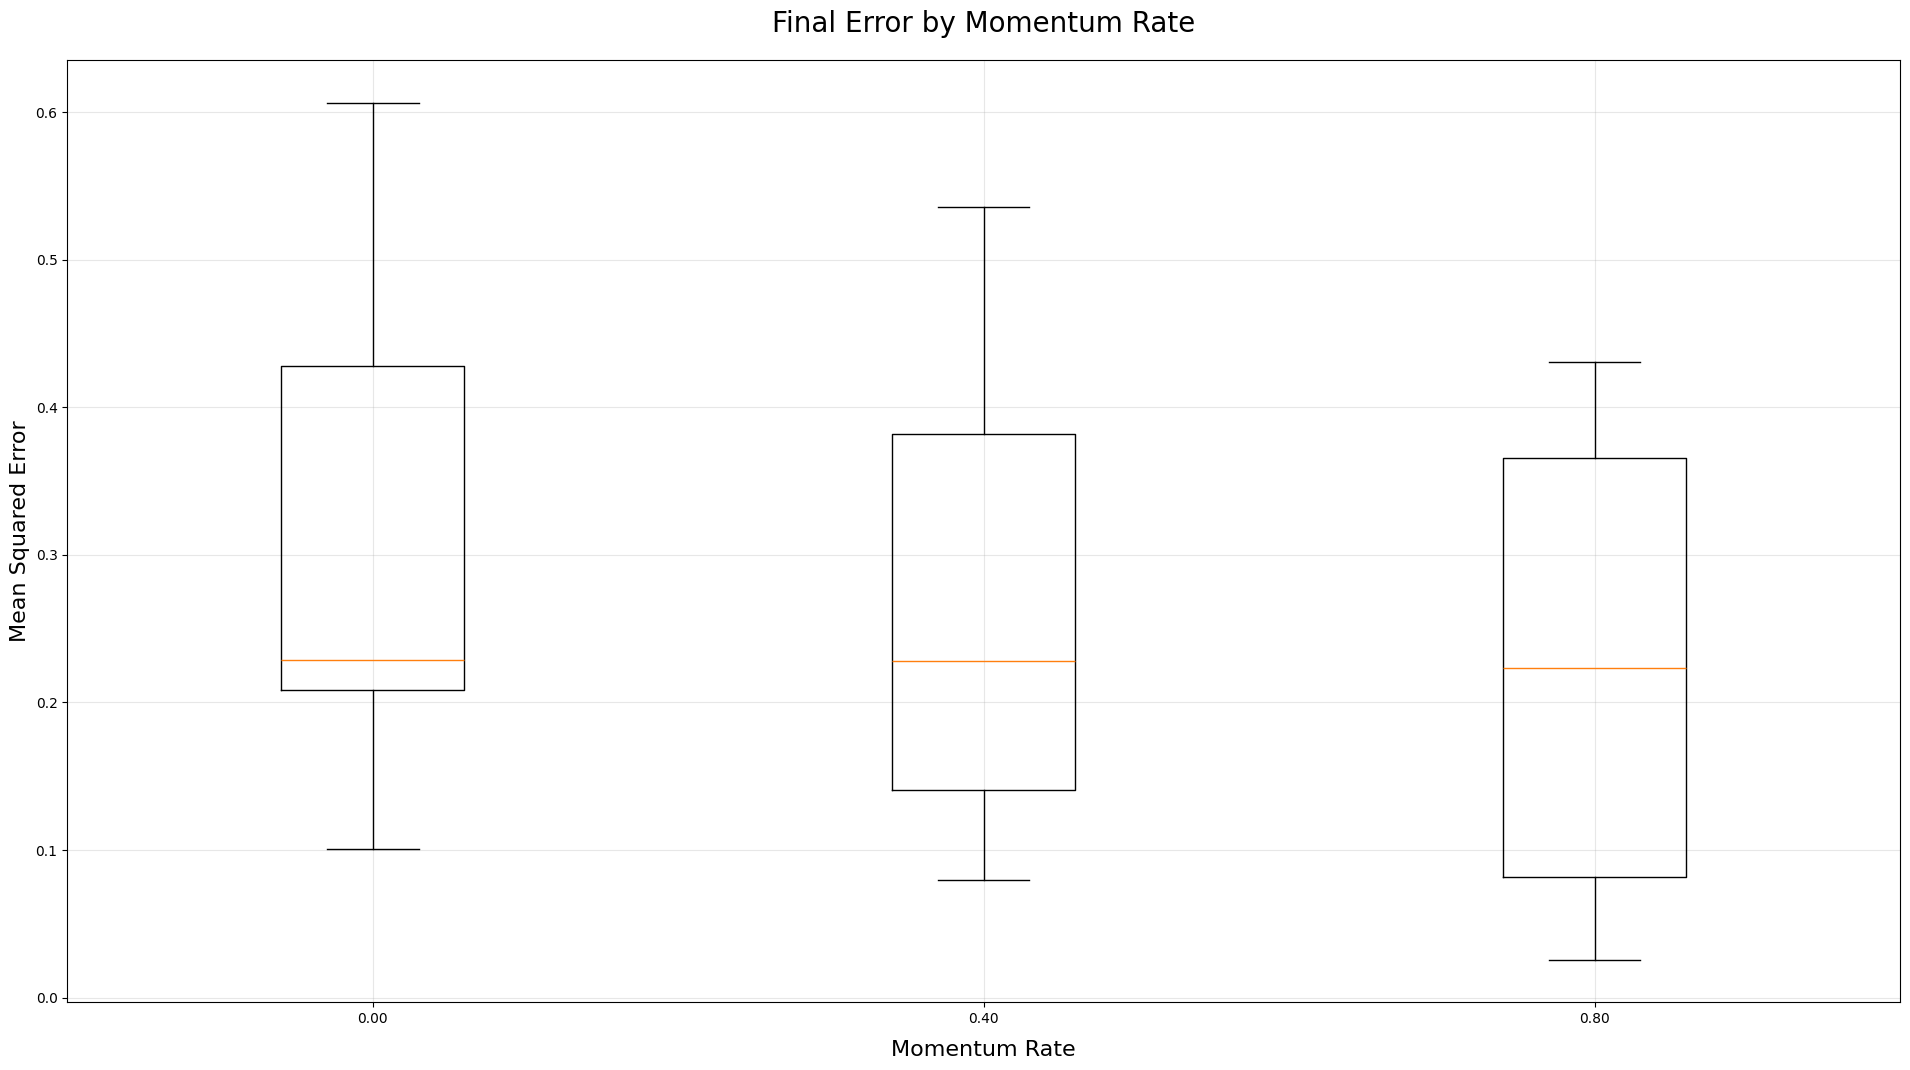

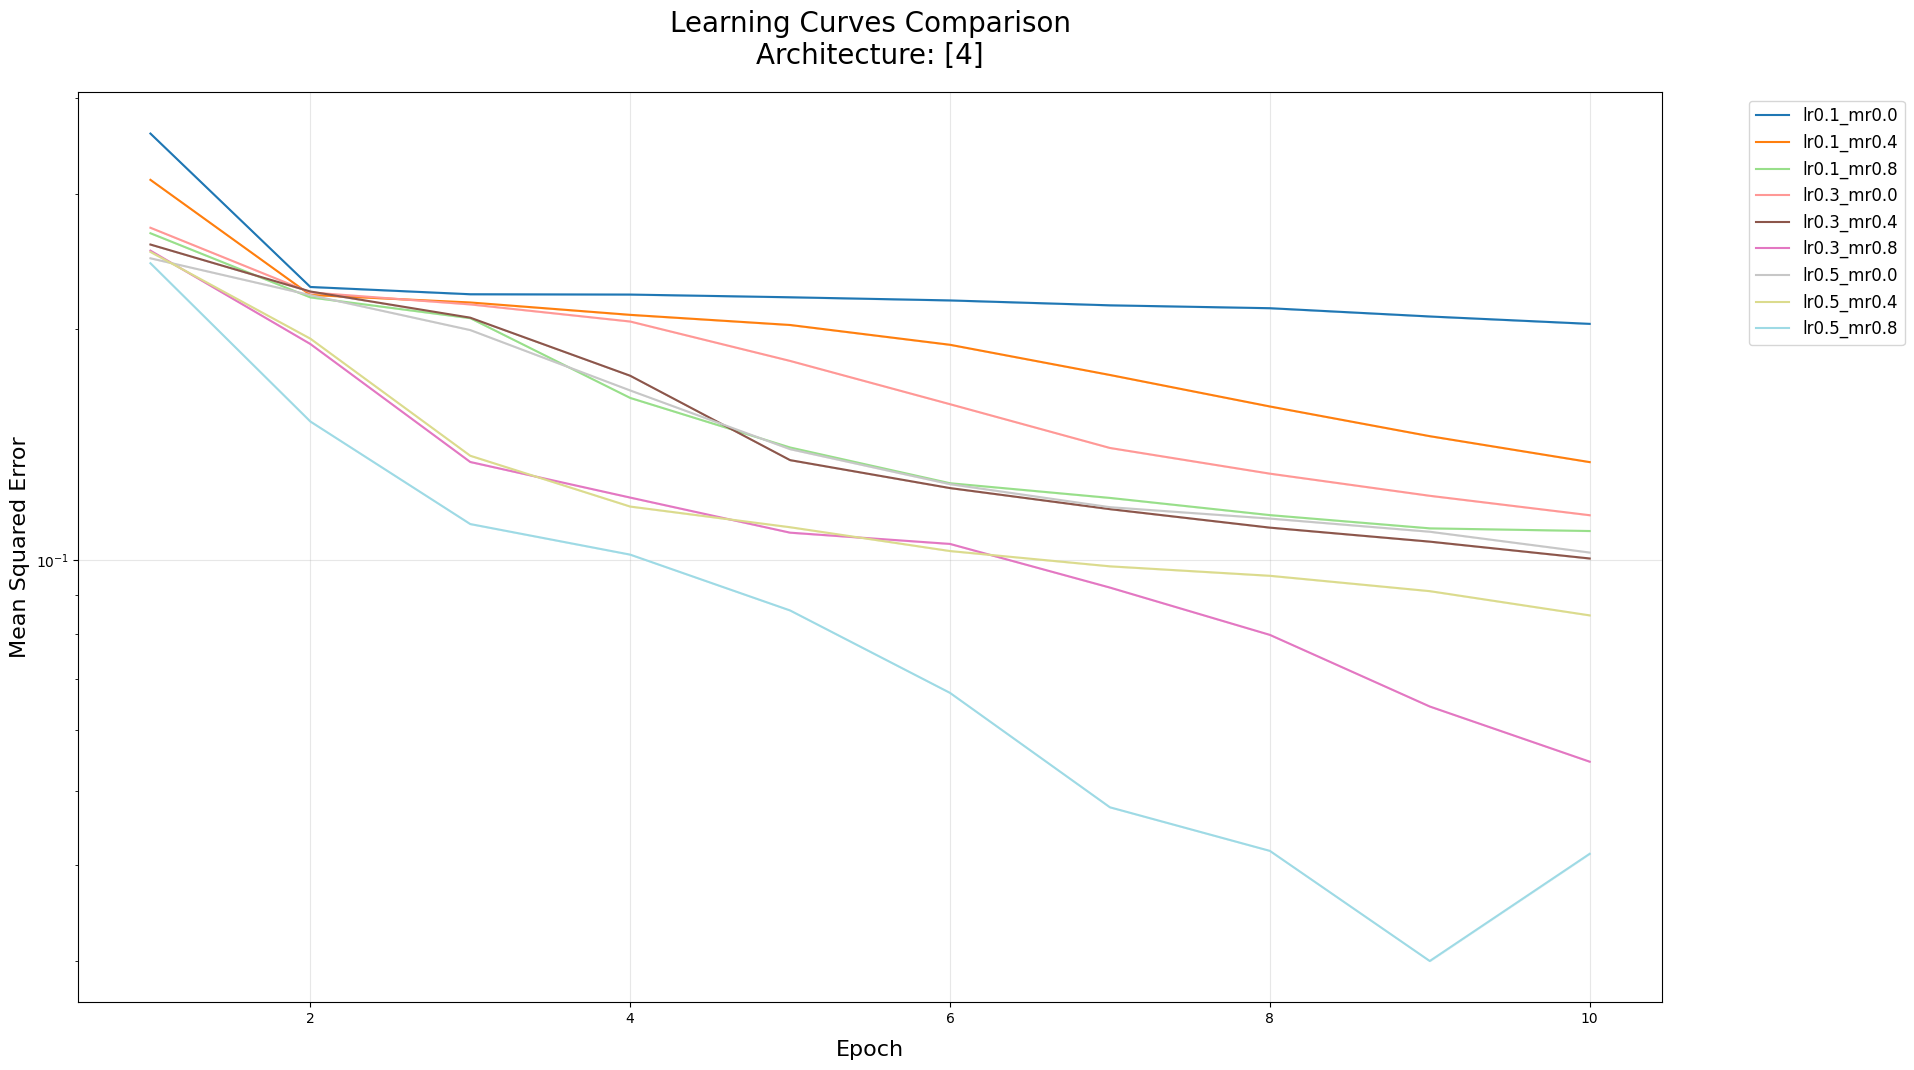

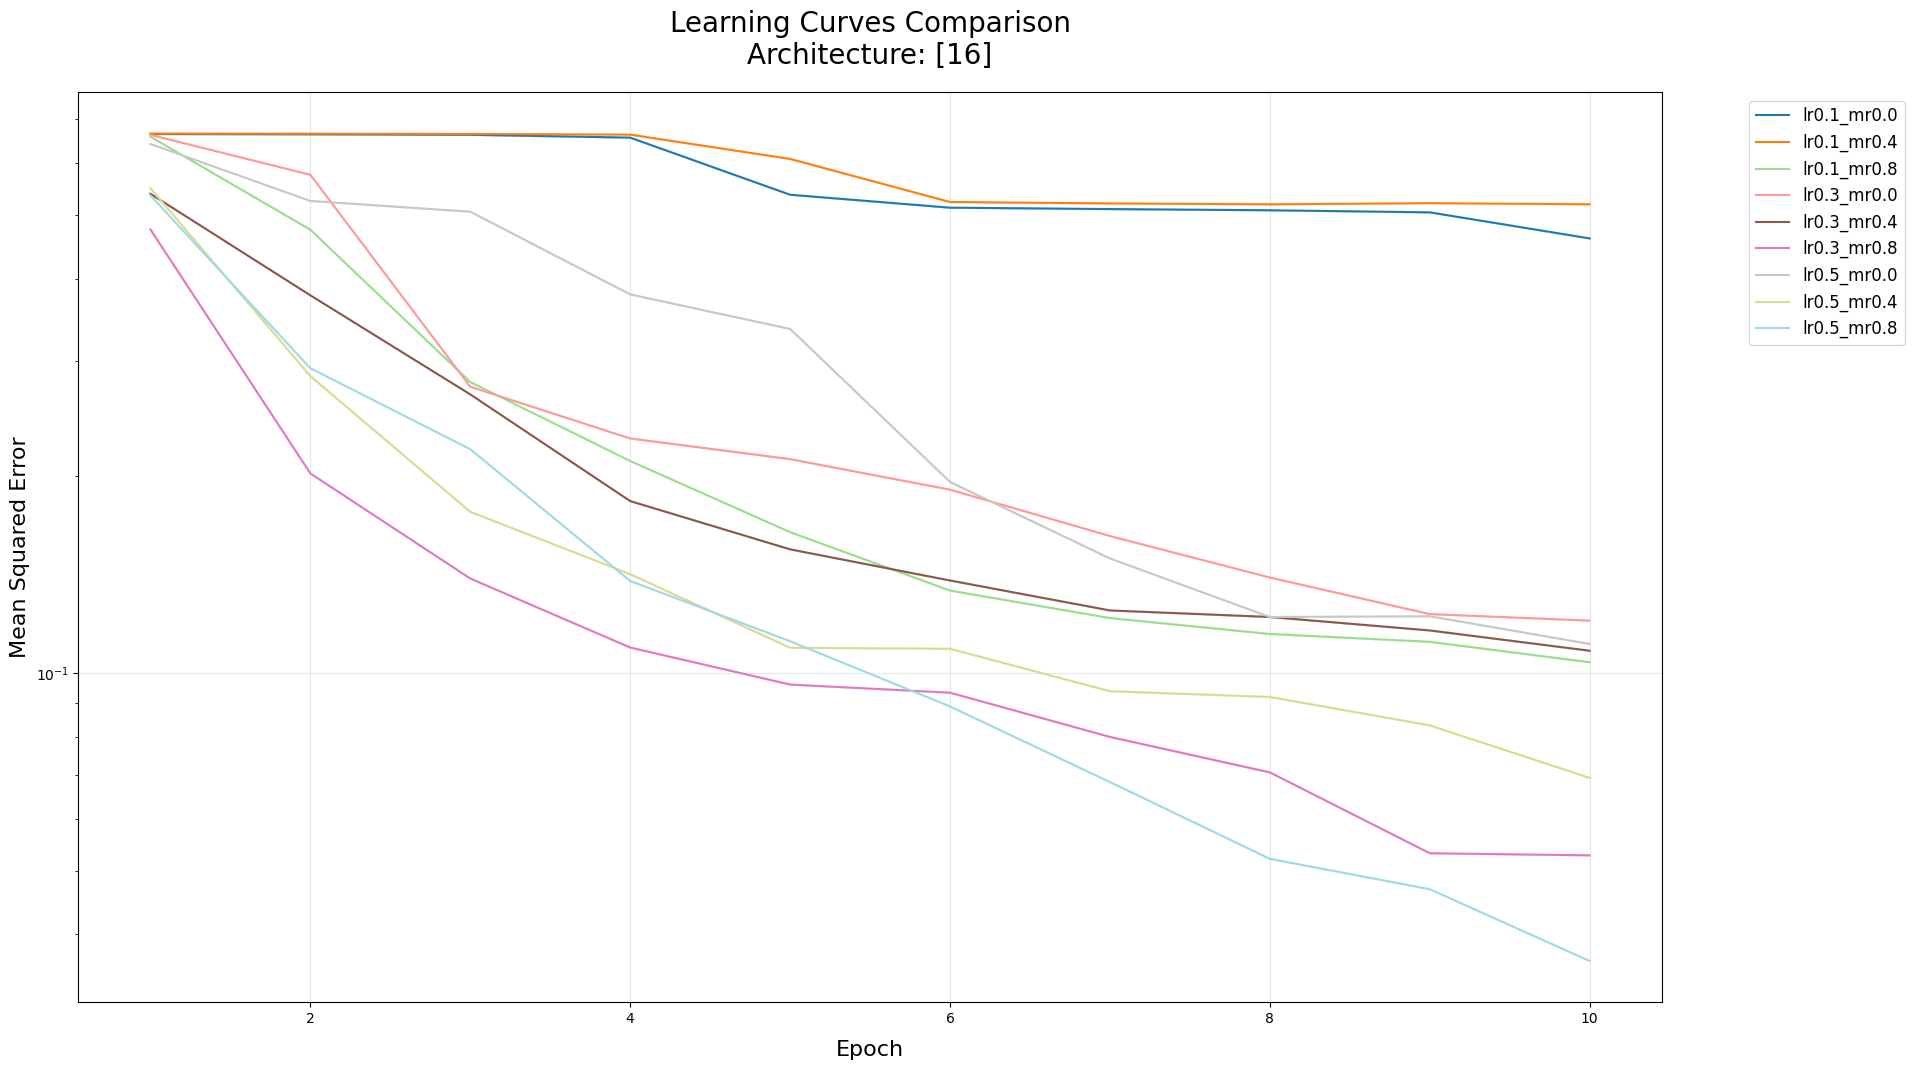

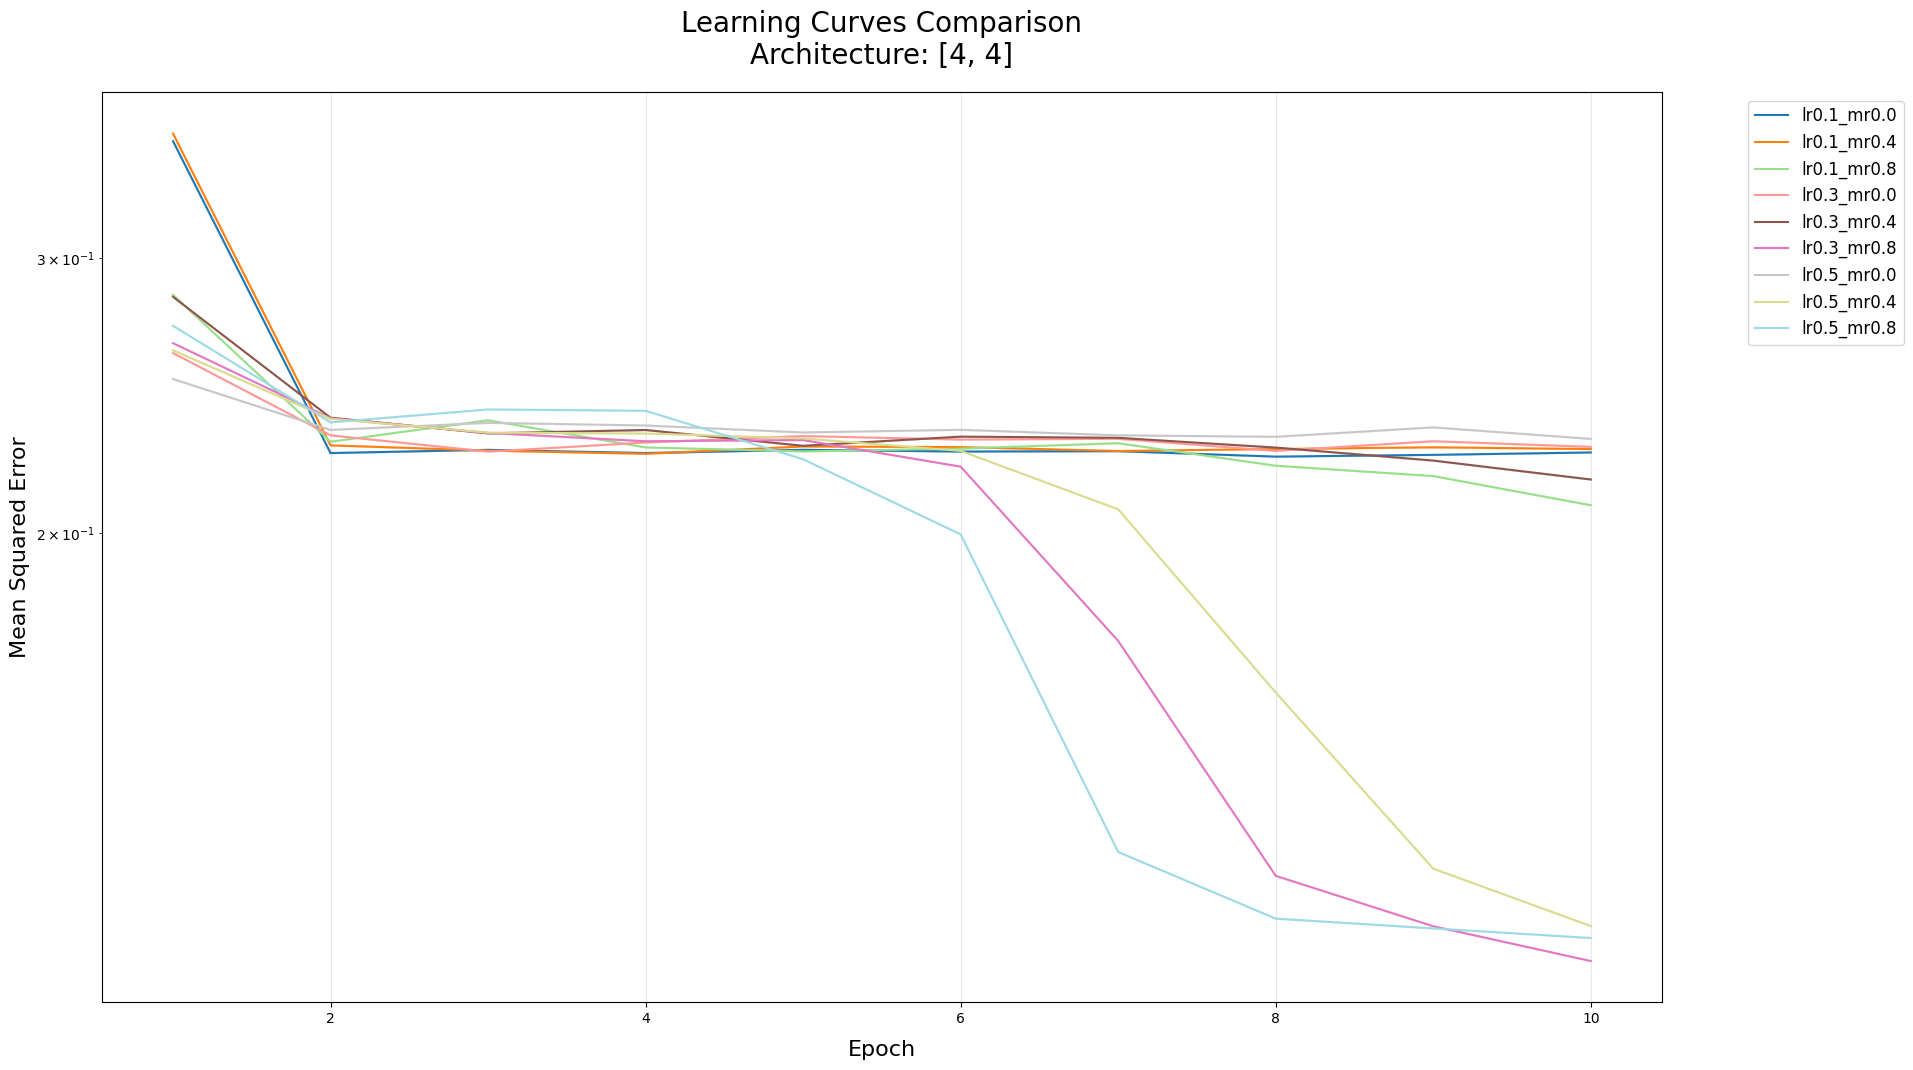

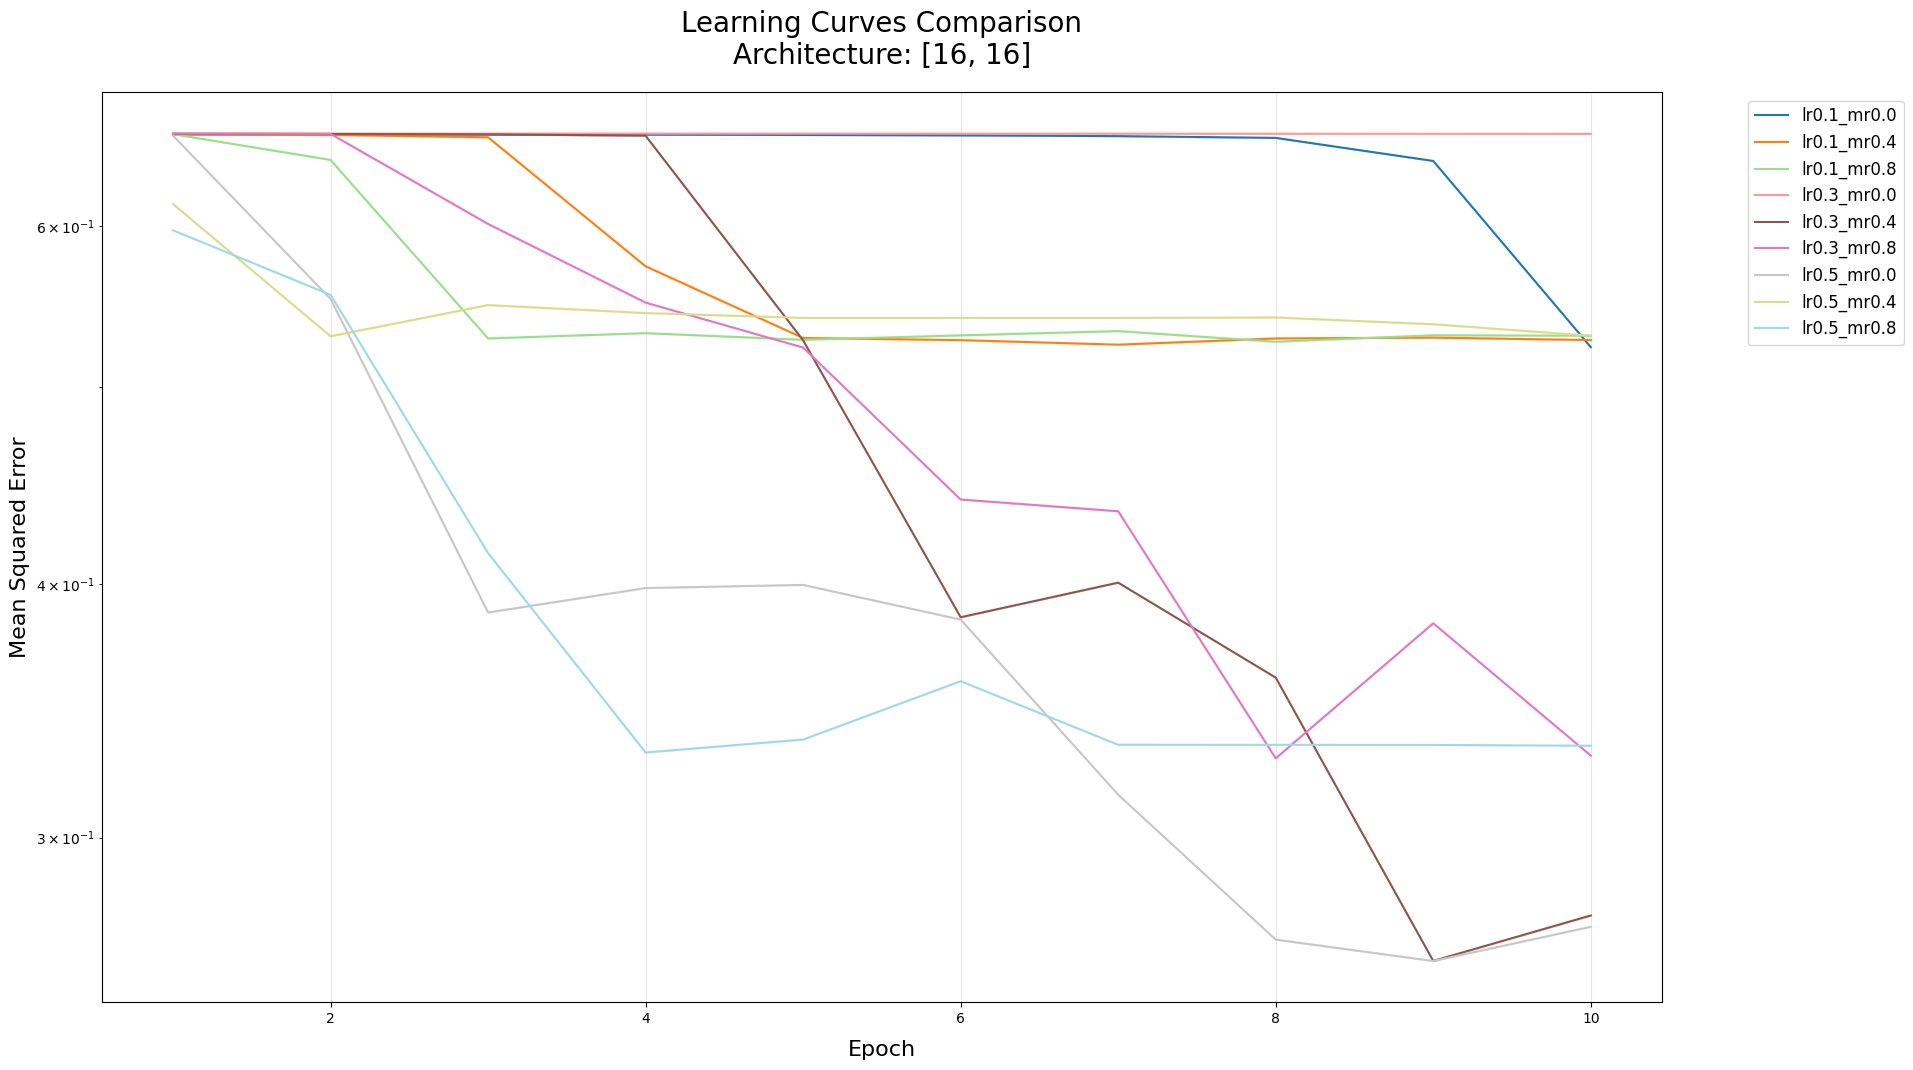

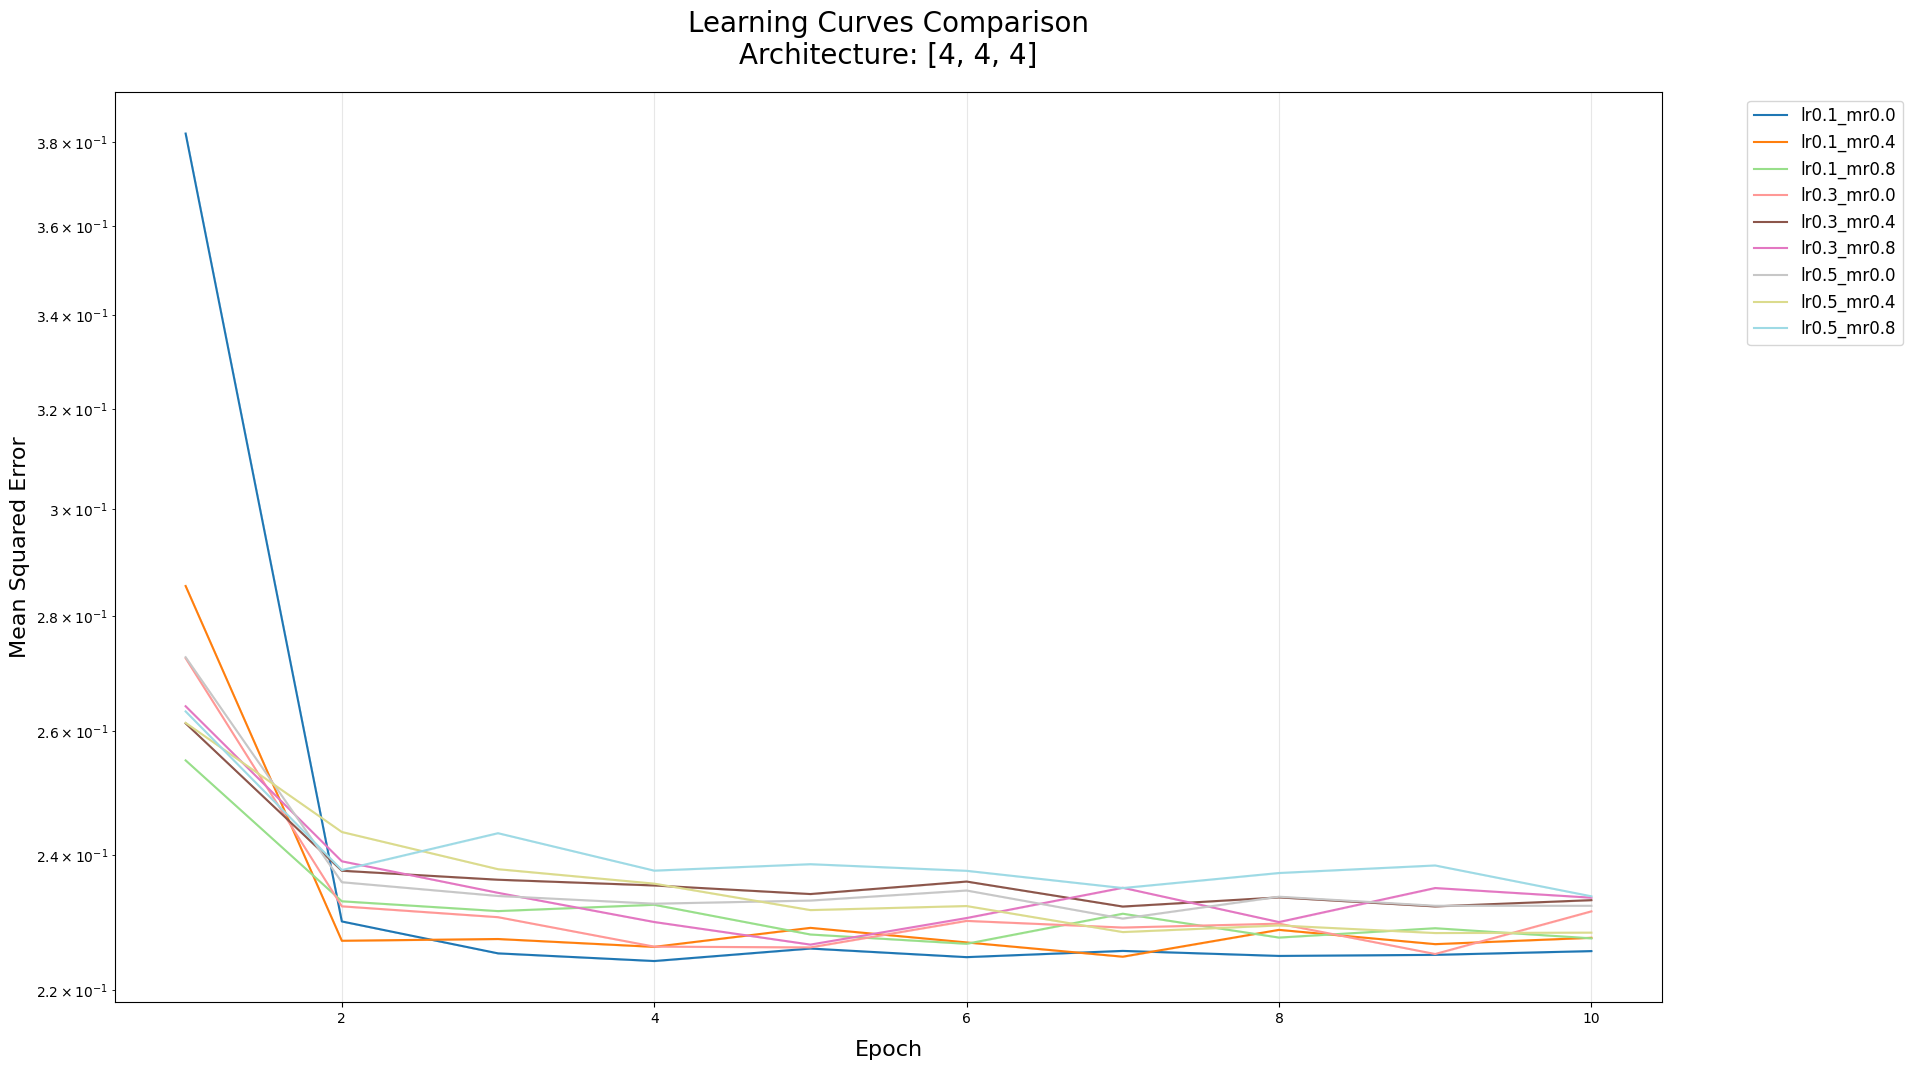

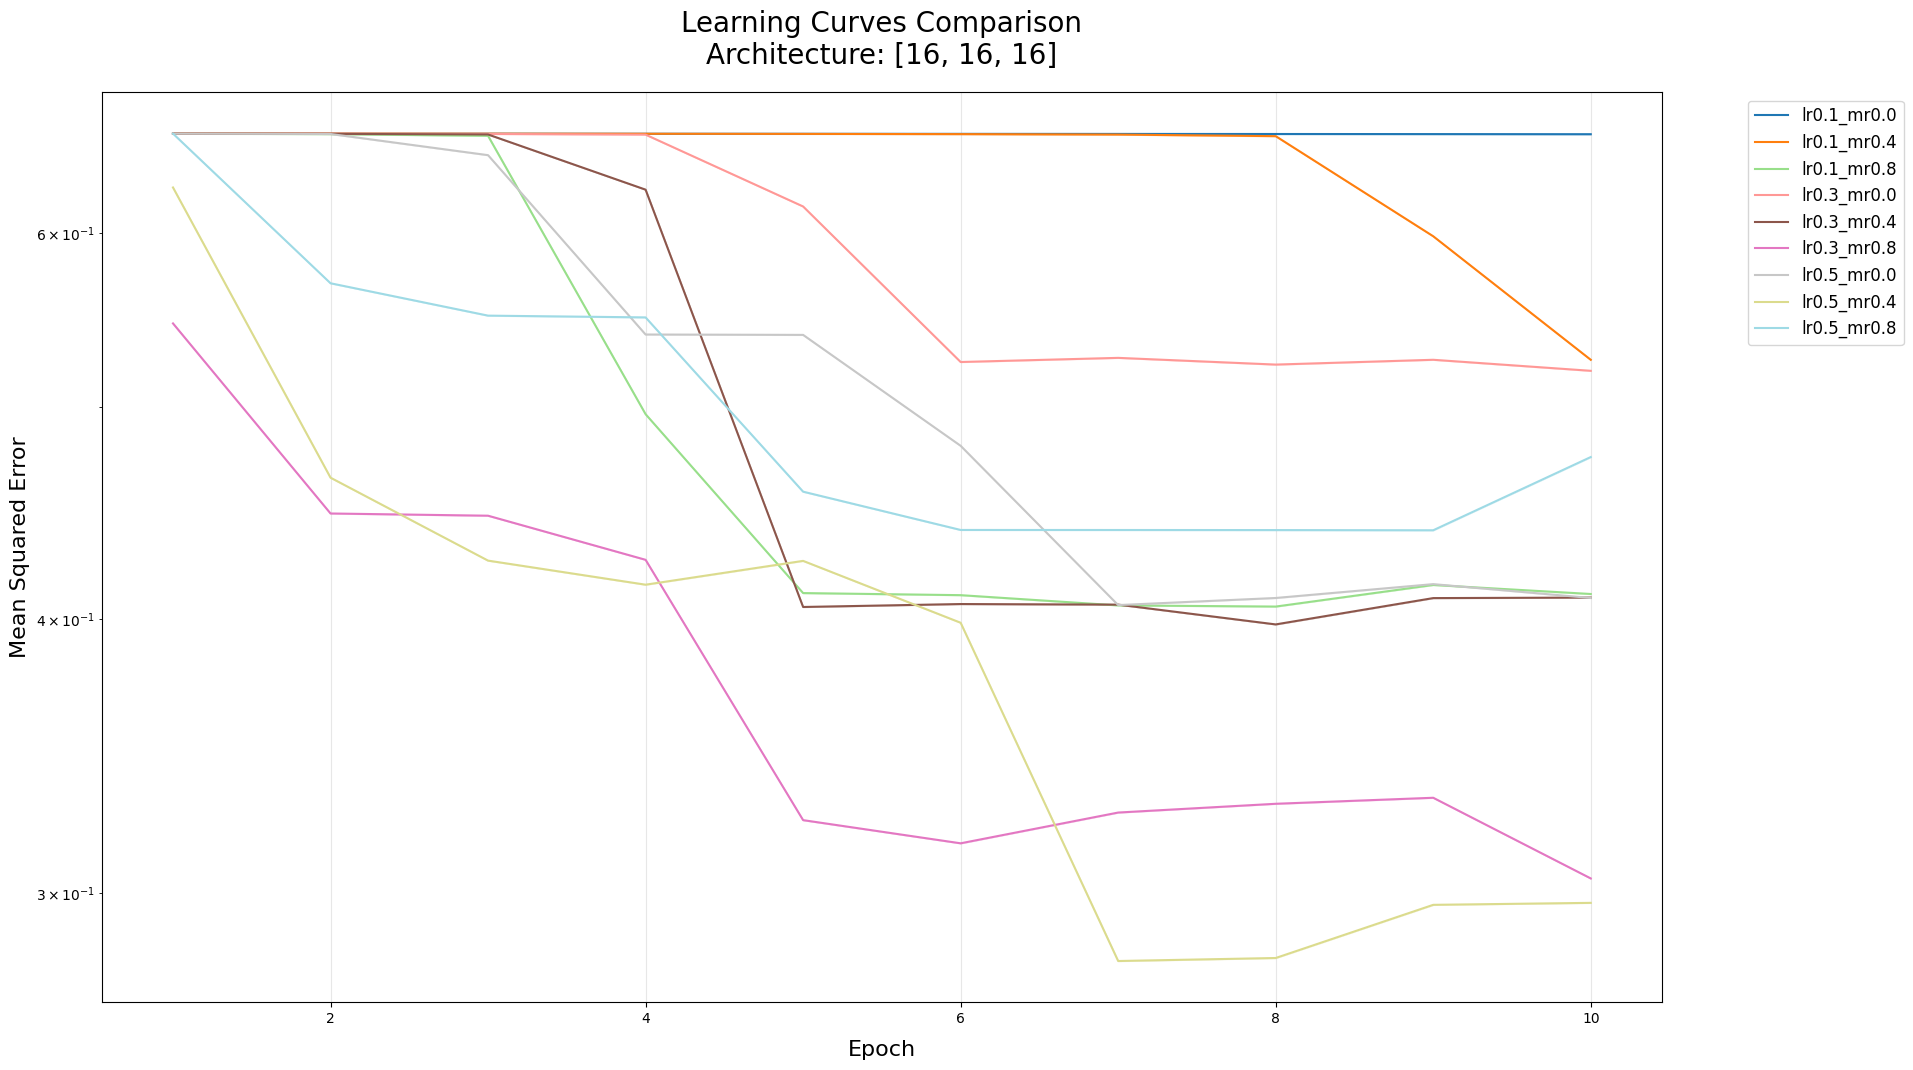

In [ ]:
if __name__ == '__main__':
    # กำหนดพารามิเตอร์ที่จะทดสอบ
    hidden_layers = [
        [4], [16],  # 1 hidden layer
        [4, 4], [16, 16],  # 2 hidden layers
        [4, 4, 4], [16, 16, 16]  # 3 hidden layers
    ]
    learning_rates = [0.1, 0.3, 0.5]
    momentum_rates = [0.0, 0.4, 0.8]

    # ให้ผู้ใช้เลือกชุดข้อมูล
    print("เลือกชุดข้อมูลที่ต้องการทดสอบ:")
    print("1: Iris Dataset")
    print("2: Cross Dataset")
    print("3: Ellipse Dataset")
    print("4: ทดสอบทั้งหมด")

    choice = input("กรุณาเลือก (1-4): ")

    datasets = {
        '1': ('iris.pat', 'iris'),
        '2': ('cross.pat', 'cross'),
        '3': ('ellipse.pat', 'ellipse')
    }

    if choice == '4':
        test_cases = ['1', '2', '3']
    else:
        test_cases = [choice]

    for case in test_cases:
        if case in datasets:
            file_path, dataset_type = datasets[case]
            print(f"\nTesting with {dataset_type} dataset:")

            # อ่านและเตรียมข้อมูล
            x, d = read_data(file_path, dataset_type)
            if dataset_type == 'iris':  # normalize เฉพาะ iris
                x, _, _ = normalization(x)

            # ทำการทดลอง
            results, learning_curves = experiment(
                x, d,
                hidden_layers=hidden_layers,
                learning_rates=learning_rates,
                momentum_rates=momentum_rates,
                n_trials=1,
                k_folds=10,
                max_epochs=10,
                desired_error=0.01
            )

            # พล็อตผลการทดลอง
            plot_comparison(results, dataset_type)
            plot_learning_curves(learning_curves, dataset_type)

In [ ]:
from google.colab import files

# เลือก dataset ที่ต้องการดาวน์โหลดรูป
dataset_type = input("ใส่ชื่อ dataset ที่ต้องการดาวน์โหลดรูป (iris, cross, หรือ ellipse): ")

# กำหนด architectures ที่มี
architectures = ['[4]', '[16]', '[4, 4]', '[16, 16]', '[4, 4, 4]', '[16, 16, 16]']

files.download(f'{dataset_type}_accuracy.png')
files.download(f'{dataset_type}_convergence.png')
files.download(f'{dataset_type}_error.png')

# ดาวน์โหลดรูป learning curves ของทุก architecture
for arch in architectures:
    files.download(f'{dataset_type}_learning_curves_{arch}.png')

ใส่ชื่อ dataset ที่ต้องการดาวน์โหลดรูป (iris, cross, หรือ ellipse): iris


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>